<center> <h1>Data Science Bootcamp at Spark Summit </h1> <br/> </center>

<center> <h3>Analyze data and build a dashboard with Spark, notebooks, and PixieDust</h3> <br/> </center>

Interactive notebooks are powerful tools for fast and flexible experimentation and data analysis. Notebooks can contain live code, static text, equations and visualizations. In this lab, we will walk through how to use PixieDust with Spark and Notebooks to analyze open data around traffic accidents in San Francisco and then build charts and maps to discover insights. We will then show how to build a dashboard that drills down into specific areas and how to combine multiple data sources like crime or speeding zones to extract even more insights..  

<center>
![pixiedust](https://developer.ibm.com/clouddataservices/wp-content/uploads/sites/85/2017/03/pixiedust200.png)
<br/>
</center>

<center>
Learn more about PixieDust [Here](https://www.ibm.com/analytics/us/en/watson-data-platform/pixiedust/)
</center>
<center>
You may access the complete tutorial with step by step instructions here: [https://www.slideshare.net/DTAIEB/pixie-dust-overview](https://www.slideshare.net/DTAIEB/pixie-dust-overview)  
  
</center>
<br/>


In [2]:
# Before, you can use the PixieDust library it must be imported into the notebook.

import pixiedust

## Import San Francisco Traffic accidents data into the Notebook
Source: [San Francisco Open Data](https://datasf.org/opendata)
> Take a moment to explore all the data available at this site

In [3]:
# With PixieDust, you can easily load CSV data from a URL into a PySpark DataFrame in the notebook.

accidents = pixiedust.sampleData("https://data.sfgov.org/api/views/vv57-2fgy/rows.csv?accessType=DOWNLOAD")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Creating pySpark DataFrame for 'https://data.sfgov.org/api/views/vv57-2fgy/rows.csv?accessType=DOWNLOAD'. Please wait...
Successfully created pySpark DataFrame for 'https://data.sfgov.org/api/views/vv57-2fgy/rows.csv?accessType=DOWNLOAD'


# Initial exploration

After successfully importing PixieDust and loading the sample data, we can use the ***display*** API to quickly browse through and visualize the data to see if we can obtain any immediate insights.  

For example:
### In which police district do the most traffic accidents occur?

```
(Pie Chart - Options: Keys = PdDistrict, Values = IncidntNum, Aggregation = Count)
```

We can also dig one level deeper by clustering by how each accident was resolved:

```
(Cluster By: Resolution)
```

### On what day of the week do the most traffic accidents occur?

```
(Bar Chart - Options: Keys = DayOfWeek, Values = IncidntNum, Aggregation = Count)
```

> Take a moment to explore the possibility of the Display API by watching this [video](https://www.youtube.com/watch?v=FoOHFlkCaXI) 


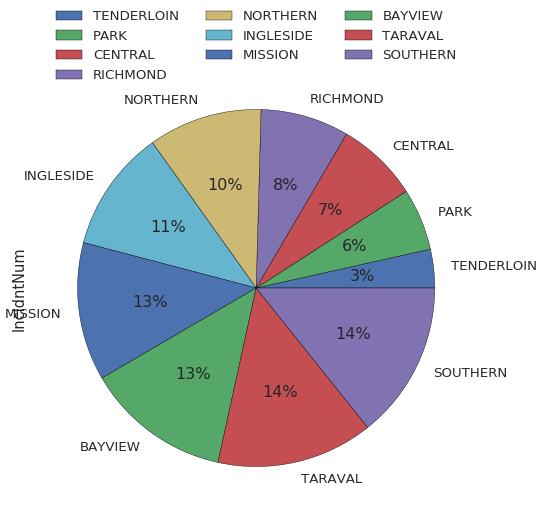

In [3]:
display(accidents)

# More data Exploration and Hypothesis
Immediately, we can identify a couple of areas of interest in our data without having to write a single line of code:

1) Most accidents happen in the Southern and Taraval police districts, and

2) Most accidents happen on Wednesdays and Thursdays.

We can also see that our data needs some cleansing if we want to make analysis easier.  Specifically:

- The `Time` field is a string, so we'll need to add an `Hour` column if we want to see the time of day when most accidents occur, and
- The `DayOfWeek` values are rendered in alphabetical order by default instead of chronological order, so we should rename them to make it easier to see how the number of accidents changes over the course of the week, and
- We should condense the outcome types of each traffic accident if we want to see the most common resolutions of traffic accidents in each police district, since the clustering above was unclear.

Let's cleanse the data and re-investigate before moving on:

> Note: the next cell is using PySpark APIs to manipulate the data. You can find more information on these APIs [here](http://spark.apache.org/docs/1.6.0/api/python/pyspark.sql.html)

In [4]:
from pyspark.sql.functions import udf
from pyspark.sql.types import *

# Get the hour value of a time string
# e.g. getHour("05:30") = 5
def getHour(s):
    return int(s.split(':')[0])

hr_udf = udf(getHour,IntegerType())

# Rename weekdays to enable mini time-series analysis
accidents = accidents.na.replace\
    (['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],\
    ['1-Monday','2-Tuesday','3-Wednesday','4-Thursday','5-Friday','6-Saturday','7-Sunday'],\
    'DayOfWeek')

# Add Hour column and refine outcomes from traffic accidents
accidents = accidents.withColumn("Hour",hr_udf(accidents['Time']))\
    .withColumn("Res",\
    udf(lambda x: 'Arrest' if 'ARREST' in x else 'No Resolution' if x == 'NONE' else 'Other',StringType())\
    (accidents['Resolution']))


## We are now ready for more data exploration
### Hypothesis: Do accidents in one police district result in more arrests than other police districts?

```
(Bar Chart - Options: Keys = PdDistrict, Values = IncidntNum, Aggregation = Count, Cluster By: Res)
```

### Question: How does the number of accidents change over the course of the week?

```
(Line Chart - Options: Keys = DayOfWeek, Values = IncidntNum, Aggregation = Count)
```

In [5]:
display(accidents)

## What have we learned
A few lines of code makes it a lot easier to see that:

1) Accidents in the Richmond police district are much more likely to result in arrest than all other districts, and

2) The number of accidents peaks during the middle of the week, but decreases afterwards as the week winds down.

## Now let's focus on the Taraval police district using some friendly SQL notation:

In [5]:
accidents.registerTempTable("accidents")
taraval = sqlContext.sql("SELECT * FROM accidents WHERE PdDistrict='TARAVAL'")

### Question: Where in Taraval do most accidents happen?

```
(Map - Options: Keys = [X,Y], Values = IncidntNum, Aggregation = Count,
Renderer: mapbox, kind: chloropleth-cluster)
```

### Question: What time of day do most accidents occur?

```
(Line Chart - Options: Keys = Hour, Values = IncidntNum, Aggregation = Count)
```

In [6]:
display(taraval)

## What have we learned:
Most of the results from looking at the accident times are unsurprising:

- Less accidents during very early morning (people probably sleeping),
- Steady increase in number of accidents during morning commuting hours,
- Less accidents during mid-evening (people probably eating dinner), and
- (Sadly) more accidents late at night.

The interesting thing here is the sudden spike in accidents during mid-afternoon (2-3PM) - twice as many accidents happen during this two-hour window!

# Further questions

In analyzing the geographical data, we can see a couple of clusters where accidents occur more frequently in Taraval - the southeastern corner looks particularly crowded.  Some useful questions to ask at this point are:

### Does crime has an effect on the number of accidents?

### Are there more accidents in these areas because more people speed there?

### Do traffic calming devices reduce the number of accidents?

We can test these hypotheses in two ways:

1) Download datasets for speeding data and traffic calming in San Francisco and simply use the `display` API to visualize speeding zones and areas with traffic calming devices separately.

2) Build a **Pixie App**, which encapsulates everything we have discussed thus far into an interactive way to explore multiple views of the data.

Only basic HTML and JavaScript are needed to write a Pixie App, so you don't have to learn any new languages or frameworks.  In particular, a Pixie App will allow us to overlay mapping layers, and therefore give us a clearer view into the problem we are investigating.

# Building the PixieApp Dashboard

### What you'll need:
- Create a Mapbox trial user account and token [here](https://www.mapbox.com/help/create-api-access-token)
- Mapbox layers Documentation: [circle](https://www.mapbox.com/mapbox-gl-js/style-spec/#layers-circle), [fill](https://www.mapbox.com/mapbox-gl-js/style-spec/#layers-fill), [symbols](https://www.mapbox.com/mapbox-gl-js/style-spec/#layers-symbol)
- Browse the data on [San Francisco Open Data](https://datasf.org/opendata) to get the GeoJSON url
- Some understanding of [Jinja2 template](http://jinja.pocoo.org/docs/dev/templates)
- A Quick read of [PixieApp documentation]()

### FAQ about the code below:
- How do we get the pixiedust options in self.mapJSONOptions?
> - Call display() on a new cell  
> - Graphically select the options for your chart  
> - Select View/Cell Toobar/Edit metadata menu  
> - Click on the “Edit Metadata” button and copy the pixiedust metadata  
- What's the self.setLayers call for?
> This is a method from the MapboxBase class used to specify the custom layer definitions array.  
> The fields are:  
>  - name: Layer name  
>  - url: geojson url to download the data from
>  - type: (optional) style type e.g Symbol. If not defined, then default value will be infered from geojson geometry
>  - paint: (optional) paint style, see appropriate documentation e.g. [circle](https://www.mapbox.com/mapbox-gl-js/style-spec/#layers-circle)  
>  - layout: (optional) layout style, see appropriate documentation e.g. [fill](https://www.mapbox.com/mapbox-gl-js/style-spec/#layers-fill)
- How do I find new layer data to add?
> Just go to [San Francisco Open Data](https://datasf.org/opendata), browse the data and click on the export button. You should see a geojson link among others (warning: not all datasets have a geojson link, if you don't find it, then move on to another one)
- What does the mainScreen method do?
> This is a PixieApp View associated with the default route. See [PixieApp documentation]() for more information.
- What's the {{...}} notation in the mainScreen markup for?
> This is a jinja2 template notation to call server side Python code see [Jinja2 template](http://jinja.pocoo.org/docs/dev/templates) for more info

In [4]:
from pixiedust.display.app import *
from pixiedust.apps.mapboxBase import MapboxBase

@PixieApp
class SFDashboard(MapboxBase):
    def setup(self):
        self.mapJSONOptions = {
          "mapboxtoken": "XXXX",
          "chartsize": "90",
          "aggregation": "SUM",
          "rowCount": "500",
          "handlerId": "mapView",
          "rendererId": "mapbox",
          "valueFields": "IncidntNum",
          "keyFields": "X,Y",
          "basemap": "light-v9"
        }
        self.setLayers([
        {
            "name": "Speeding",
            "url": "https://data.sfgov.org/api/geospatial/mfjz-pnye?method=export&format=GeoJSON"
        },
        {
            "name": "Traffic calming",
            "url": "https://data.sfgov.org/api/geospatial/ddye-rism?method=export&format=GeoJSON",
            "type": "symbol",
            "layout": {
                "icon-image": "police-15",
                "icon-size": 1.5
            }
        },
        {
            "name": "Police Districts",
            "url": "https://data.sfgov.org/api/geospatial/wkhw-cjsf?method=export&format=GeoJSON"
        },
        {
            "name": "Crimes",
            "url": "https://data.sfgov.org/api/geospatial/ms8q-rzqw?method=export&format=GeoJSON",
            "paint":{
                "fill-color": "rgba(255,182,193,0.5)"
            }
        }
        ])
        
    def formatOptions(self,options):
        return ';'.join(["{}={}".format(key,value) for (key, value) in iteritems(options)])
    
    @route()
    def mainScreen(self):
        return """
<div class="well">
    <center><span style="font-size:x-large">Analyzing San Francisco Public Safety data with PixieDust</span></center>
    <center><span style="font-size:large"><a href="https://datasf.org/opendata" target="new">https://datasf.org/opendata</a></span></center>
</div>
<div class="row">
    <div class="form-group col-sm-2" style="padding-right:10px;">
        <div><strong>Layers</strong></div>
        {% for layer in this.layers %}
        <div class="rendererOpt checkbox checkbox-primary">
            <input type="checkbox" pd_refresh="map{{prefix}}" pd_script="self.toggleLayer({{loop.index0}})">
            <label>{{layer["name"]}}</label>
        </div>      
        {%endfor%}
    </div>
    <div class="form-group col-sm-10">
        <div id="map{{prefix}}" pd_entity pd_options="{{this.formatOptions(this.mapJSONOptions)}}"/>
    </div>
</div>
"""
    
SFDashboard().run(accidents,runInDialog="false")